# Imports

In [1]:
# Basic Analysis and Visualization
import sqlite3
import json
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import datetime
from datetime import timedelta

# Mapping
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
import folium
from geopy.extra.rate_limiter import RateLimiter
from folium import plugins
from folium.plugins import MarkerCluster

# Statistical OLS Regression Analysis
%matplotlib inline
import statsmodels.api as sm
from statsmodels.compat import lzip
from statsmodels.formula.api import ols

#Scipy sklearn Predictions
from sklearn.ensemble import GradientBoostingRegressor
from shapely.geometry import shape
from sklearn import preprocessing, cluster
import scipy.cluster
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
import plotly.express as px

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\pyproj\__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [41]:
conn = sqlite3.connect('Trial_database_all_data.db');
cur = conn.cursor();
query_all = '''

SELECT Month, Longitude, Latitude, Location, [Crime type], [Falls within], [LSOA NAME], [LSOA CODE]
FROM test_db
WHERE [Month] LIKE '2020%'
;

'''
df_crime = pd.read_sql_query(query_all, conn)

In [39]:
df_lsoa = pd.read_csv('Local_Authority_Districts_(May_2021)_UK_BFE_V3.csv')

In [56]:
city_series = df_lsoa['LAD21NM']
city_series = city_series.replace('Bristol, City of', 'Bristol')
df_lsoa['LAD21NM'] = city_series

In [42]:
df_crime['Month'] = pd.to_datetime(df_crime['Month'])
df_crime['month_of_year'] = df_crime['Month'].dt.month
df_crime['City name'] = df_crime['LSOA name'].str.replace(r'[0-9]+[A-Z]', '', regex=True).str.rstrip()

groupby_city = df_crime.groupby('City name')
groupby_lsoa = df_crime.groupby('LSOA name')

In [57]:
# Makes dataframe for each county located in the df_crime
d = {}

for name, group in groupby_city:
    d[str(name)] = group
    
city_lst = list(d.keys()) # These counties can be used as input in the hotspot_input function below

In [58]:
def hotspot_input():
    """
    Makes a map with hotspots of the county requested
    """
    city_input = input('Which city would you like to see the hotspots of?: ')
    df_city = new_df[new_df['City name'] == city_input]

    city_group = df_city.groupby('LSOA code')
    df_count = city_group[['Crime type']].count()
    df_count = df_count.reset_index()
    
    #Gets the Local Authority District code of a county
    idx_l = df_lsoa.LAD21NM[df_lsoa.LAD21NM == city_input].index.tolist()
    idx = idx_l[0]
    code = df_lsoa.loc[idx]['LAD21CD']
    
    with open('json/statistical/eng/lsoa_by_lad/topo_' + code + '.json') as f:
        states_topo = json.load(f)
    
    data_indexed = df_count.set_index('LSOA code')
  
    # looping thru the geojson object and adding a new property(crime_count)
    # and assigning a value from our dataframe
    for i in range(len(states_topo['objects'][code]['geometries'])):
        states_topo['objects'][code]['geometries'][i]['properties']['crime_count'] = int(df_count.loc[i]['Crime type'])
     
    # Makes the map
    gmap = folium.Map(location = [df_city.Latitude.mean(), df_city.Longitude.mean()], zoom_start=11)
    folium.TileLayer('cartodbpositron').add_to(gmap)

    # Makes the areas in the map
    choropleth = folium.Choropleth(geo_data =states_topo, 
               data = df_count, columns = ['LSOA code','Crime type'], topojson='objects.' + code, 
               key_on='feature.properties.LSOA11CD', fill_color= 'YlOrBr', fill_opacity = 0.6,
                line_opacity=0.2, legend_name = 'Count CRIMES').add_to(gmap)

    # Adds the tooltip
    choropleth.geojson.add_child(folium.features.GeoJsonTooltip(
        fields=['LSOA11NM', 'crime_count'],
        aliases=['Neighborhood', 'crime count'],
        style=('background-color: grey; color: white;')
        )
)
    
    return gmap

In [59]:
hotspot_input()

Which city would you like to see the hotspots of?: Bristol


# Looking at whether Month of the Year and Year affect prediction of crime in North-South direction (Latitude)

In [31]:
all_models = {}

X = np.atleast_2d(city['month'].values).T
y = np.atleast_2d(city['Latitude'].values).T

xx = np.atleast_2d(np.linspace(0, 10, 668472)).T
xx = xx.astype(np.float32)

alpha = 0.95

In [32]:
# Parameters for the models
common_params = dict(
    learning_rate=0.05,
    n_estimators=20000,
    max_depth=2,
    min_samples_leaf=9,
    min_samples_split=9,
)

In [33]:
# Models used
gbr_mse = GradientBoostingRegressor(loss='squared_error', **common_params)
all_models['mse'] = gbr_mse.fit(X, y)

gbr05 = GradientBoostingRegressor(loss="quantile", alpha=0.05, **common_params)
all_models['q0.05'] = gbr05.fit(X, y)

gbr50 = GradientBoostingRegressor(loss="quantile", alpha=0.5, **common_params)
all_models['q0.5'] = gbr50.fit(X, y)

gbr95 = GradientBoostingRegressor(loss="quantile", alpha=0.95, **common_params)
all_models['q0.95'] = gbr95.fit(X, y)

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

In [34]:
y_pred = all_models["mse"].predict(X)
y_lower = all_models["q0.05"].predict(X)
y_upper = all_models["q0.95"].predict(X)
y_med = all_models["q0.5"].predict(X)

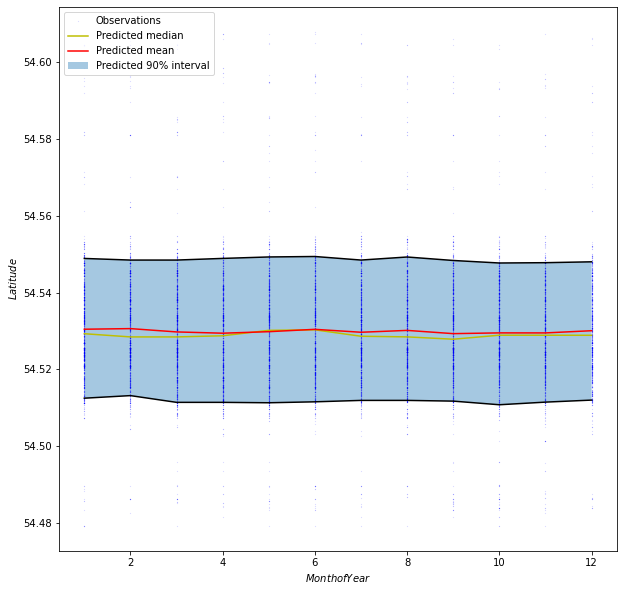

In [35]:
fig = plt.figure(figsize=(10, 10))

plt.plot(X, y, "b.", markersize=0.1, label="Observations")
plt.plot(X, y_med, "y-", label="Predicted median")
plt.plot(X, y_pred, "r-", label="Predicted mean")
plt.plot(X, y_upper, "k-")
plt.plot(X, y_lower, "k-")
plt.fill_between(X.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval")

plt.xlabel("$Month of Year$")
plt.ylabel("$Latitude$")

plt.legend(loc="upper left")
plt.show()

ypred2 = y_pred

# Looking at whether Month of the Year and Year affect prediction of crime in East-West direction (Longitude)

In [36]:
X = np.atleast_2d(city['month'].values).T
y = np.atleast_2d(city['Longitude'].values).T

xx = np.atleast_2d(np.linspace(0, 10, 668472)).T
xx = xx.astype(np.float32)

alpha = 0.95

In [37]:
common_params = dict(
    learning_rate=0.05,
    n_estimators=5000,
    max_depth=2,
    min_samples_leaf=9,
    min_samples_split=9,
)

In [38]:
gbr_mse = GradientBoostingRegressor(loss='squared_error', **common_params)
all_models['mse'] = gbr_mse.fit(X, y)

gbr05 = GradientBoostingRegressor(loss="quantile", alpha=0.05, **common_params)
all_models['q0.05'] = gbr05.fit(X, y)

gbr50 = GradientBoostingRegressor(loss="quantile", alpha=0.5, **common_params)
all_models['q0.5'] = gbr50.fit(X, y)

gbr95 = GradientBoostingRegressor(loss="quantile", alpha=0.95, **common_params)
all_models['q0.95'] = gbr95.fit(X, y)

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

In [39]:
y_pred = all_models["mse"].predict(X)
y_lower = all_models["q0.05"].predict(X)
y_upper = all_models["q0.95"].predict(X)
y_med = all_models["q0.5"].predict(X)

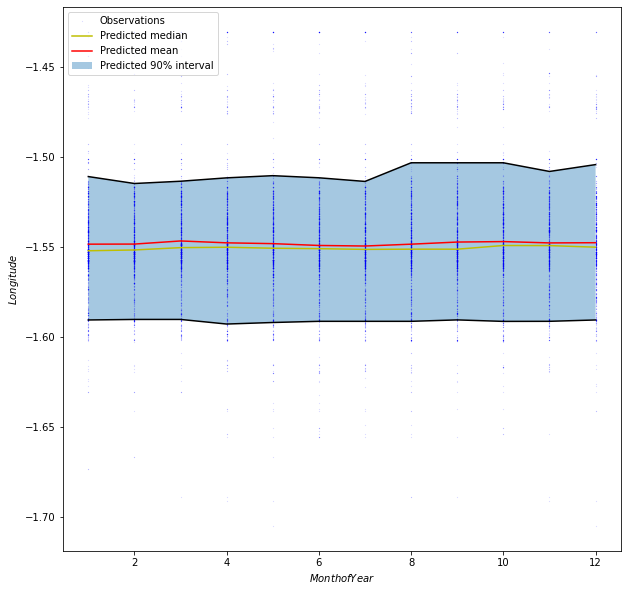

In [40]:
fig = plt.figure(figsize=(10, 10))

plt.plot(X, y, "b.", markersize=0.1, label="Observations")
plt.plot(X, y_med, "y-", label="Predicted median")
plt.plot(X, y_pred, "r-", label="Predicted mean")
plt.plot(X, y_upper, "k-")
plt.plot(X, y_lower, "k-")
plt.fill_between(X.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval")

plt.xlabel("$Month of Year$")
plt.ylabel("$Longitude$")

plt.legend(loc="upper left")
plt.show()

ypred1 = y_pred

In [41]:
data_vis = []

for i in range(len(ypred2)):
    data_vis.append([ypred2[i], ypred1[i]])

predvis = pd.DataFrame(data_vis, columns = ['ypred2 (Latitude)', 'ypred1 (Longitude)'])

data_pred = predvis[['ypred2 (Latitude)', 'ypred1 (Longitude)']].values

In [45]:
m_pred = folium.Map(location = [city.Latitude.mean(), city.Longitude.mean()], zoom_start=14)
m_pred.add_child(plugins.FastMarkerCluster(data_pred.tolist()))
m_pred.add_child(plugins.HeatMap(data_pred, radius=15))